In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [4]:
data_dir = "Data"
train_dir = os.path.join(data_dir, 'Train/Classes/')
test_dir = os.path.join(data_dir, 'Test/Classes/')

train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.3932, 0.2688, 0.2190])
Calculated stds: tensor([0.3176, 0.2311, 0.1962])


In [293]:
pretrained_size = [224,224]
#pretrained_means = [0.485, 0.456, 0.406] # not sure
#pretrained_stds= [0.229, 0.224, 0.225] 

pretrained_means = means # not sure
pretrained_stds= stds

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           #transforms.RandomCrop(pretrained_size,padding=10),
                            #transforms.RandomApply(torch.nn.ModuleList([
                             transforms.ColorJitter((0.5,1.5),(0.5,1.5),(0.5,1.5),(-0.01,0.01)),
                             #]), p=0.3),
                            transforms.RandomGrayscale(p=0.1),
                           transforms.ToTensor(),
                           #transforms.Normalize(mean = pretrained_means, 
                            #                    std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           #transforms.Pad(224, fill=0, padding_mode='constant'),
                           transforms.Resize(pretrained_size),
                            #transforms.RandomGrayscale(p=1),
                           transforms.ToTensor(),
                           #transforms.Normalize(mean = pretrained_means, 
                            #                   std = pretrained_stds)
                       ])

In [294]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

valid_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

In [295]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 829
Number of validation examples: 280
Number of testing examples: 280


In [296]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [297]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

In [298]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]
        #print(image.shape)

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

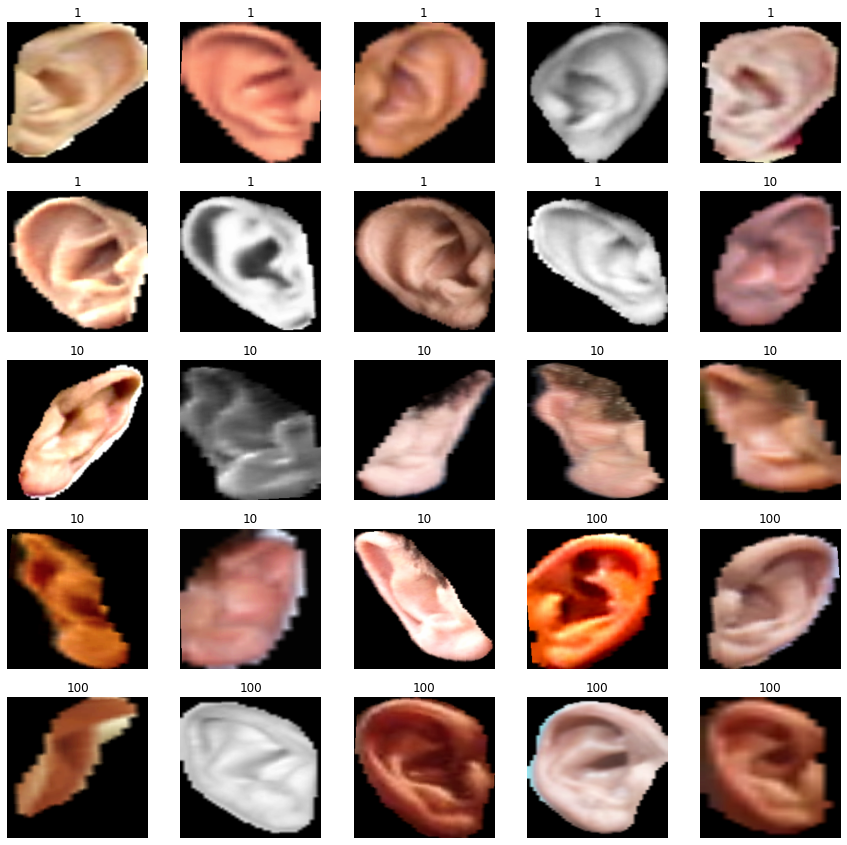

In [299]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = train_data.classes

images2, labels2 = zip(*[(image, label) for image, label in 
                           [test_data[i] for i in range(N_IMAGES)]])

plot_images(images, labels, classes)



In [300]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

In [301]:
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

In [302]:
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

In [303]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [304]:
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

In [412]:
#pretrained_model = models.resnet50(pretrained = True)
pretrained_model = models.resnet34(pretrained = True)

In [413]:
IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = len(train_data.classes)

print(OUTPUT_DIM)
print(len(test_data.classes))

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

100
100


In [414]:
pretrained_model.fc = fc

In [415]:
#model = ResNet(resnet50_config, OUTPUT_DIM)
model = ResNet(resnet34_config, OUTPUT_DIM)

In [416]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [417]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [420]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


In [421]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

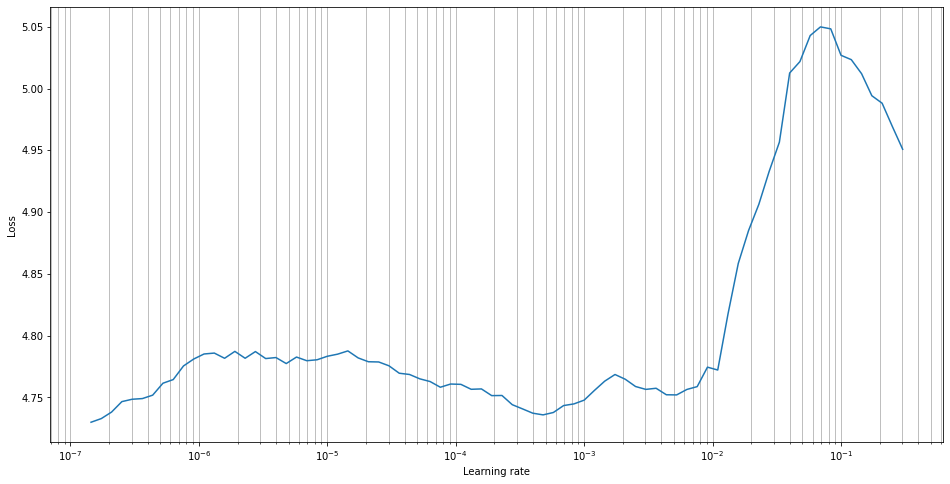

In [422]:
plot_lr_finder(lrs, losses, skip_start = 0, skip_end = 20)

In [455]:
FOUND_LR = 10e-4

In [456]:
params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]


optimizer = optim.Adam(params, lr = FOUND_LR)

In [457]:
EPOCHS = 10
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [458]:
def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [459]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [460]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [461]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [462]:
best_valid_loss = float('inf')
best_valid_acc = -float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
        
    #if valid_loss < best_valid_loss:
     #   best_valid_loss = valid_loss
      #  torch.save(model.state_dict(), 'tut5-model.pt')
    if valid_acc_1 > best_valid_acc:
        best_valid_acc = valid_acc_1
        torch.save(model.state_dict(), 'tut34-model_aug4.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 0m 8s
	Train Loss: 3.925 | Train Acc @1:   8.19% | Train Acc @5:  25.53%
	Valid Loss: 4.444 | Valid Acc @1:   2.50% | Valid Acc @5:  17.81%
Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 3.906 | Train Acc @1:   7.12% | Train Acc @5:  25.56%
	Valid Loss: 4.368 | Valid Acc @1:   3.44% | Valid Acc @5:  17.19%
Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 3.896 | Train Acc @1:   7.98% | Train Acc @5:  28.48%
	Valid Loss: 4.540 | Valid Acc @1:   4.90% | Valid Acc @5:  16.77%
Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 3.940 | Train Acc @1:   7.60% | Train Acc @5:  25.92%
	Valid Loss: 4.800 | Valid Acc @1:   1.77% | Valid Acc @5:  13.02%
Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 3.789 | Train Acc @1:  10.12% | Train Acc @5:  31.44%
	Valid Loss: 4.292 | Valid Acc @1:   4.06% | Valid Acc @5:  18.02%
Epoch: 06 | Epoch Time: 0m 8s
	Train Loss: 3.658 | Train Acc @1:  12.20% | Train Acc @5:  38.12%
	Valid Loss: 4.274 | Valid Acc @1:   2.81% | Valid Acc @5:  20.42%
Epoch: 07 | Epoc

In [ ]:
model.load_state_dict(torch.load('tut34-model_aug3.pt'))

test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @5: {test_acc_5*100:6.2f}%')

In [341]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [342]:
images, labels, probs = get_predictions(model, test_iterator)

In [343]:
pred_labels = torch.argmax(probs, 1)

In [352]:
corrects = torch.eq(labels, pred_labels)

In [353]:
def plot_images(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.4)

In [354]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

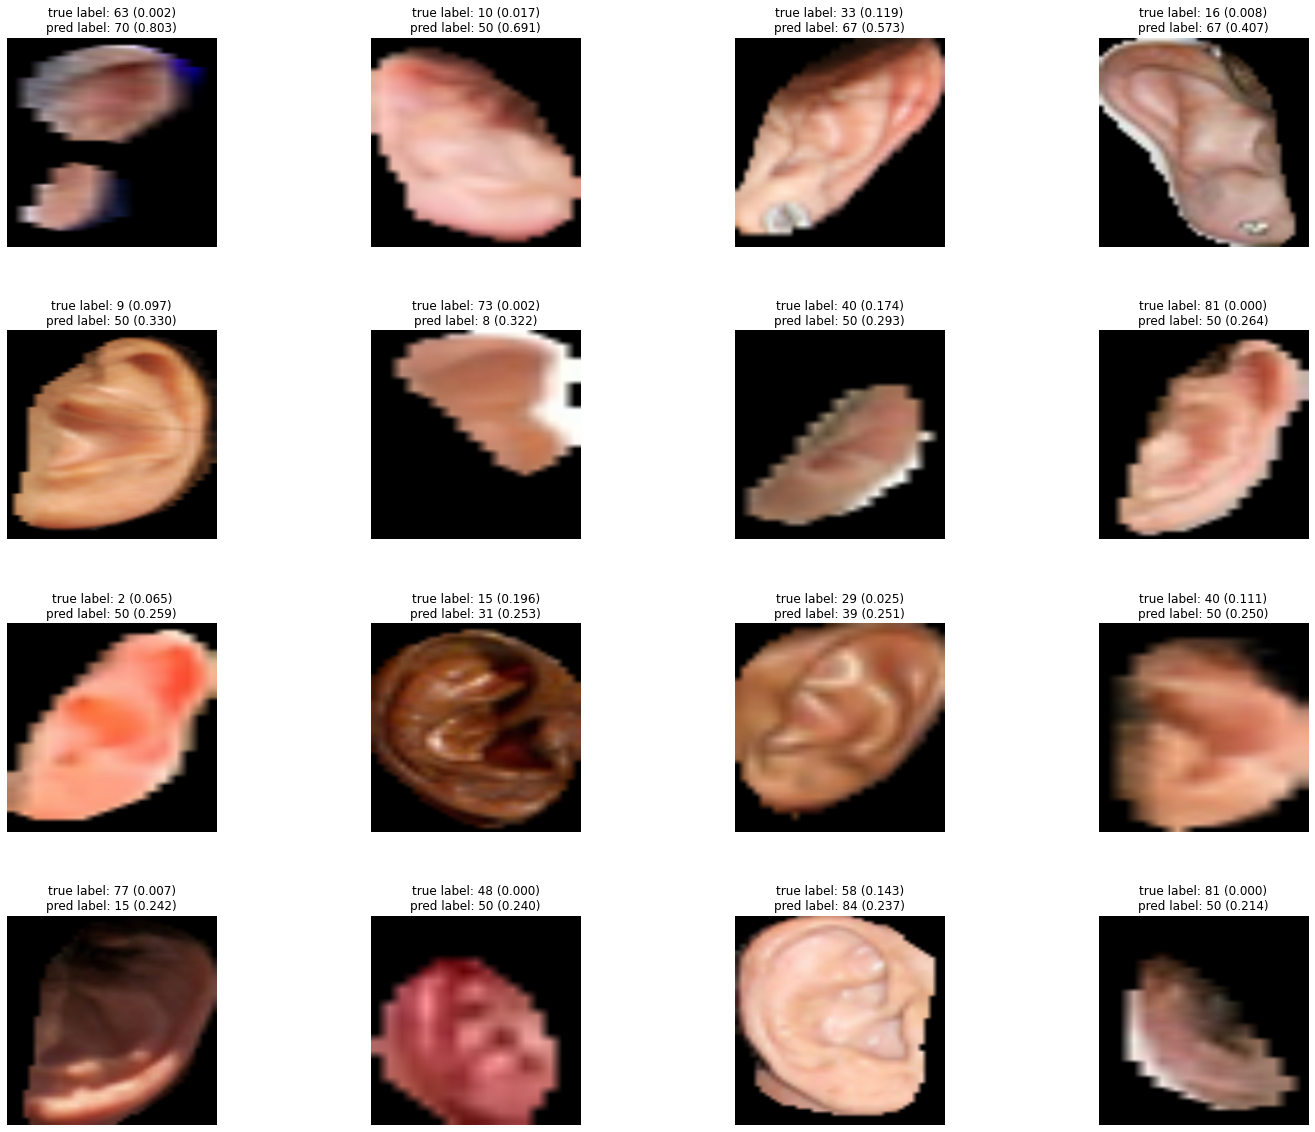

In [355]:
N_IMAGES = 18

plot_images(incorrect_examples, classes, N_IMAGES)

In [356]:
correct_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if correct:
        correct_examples.append((image, label, prob))

correct_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

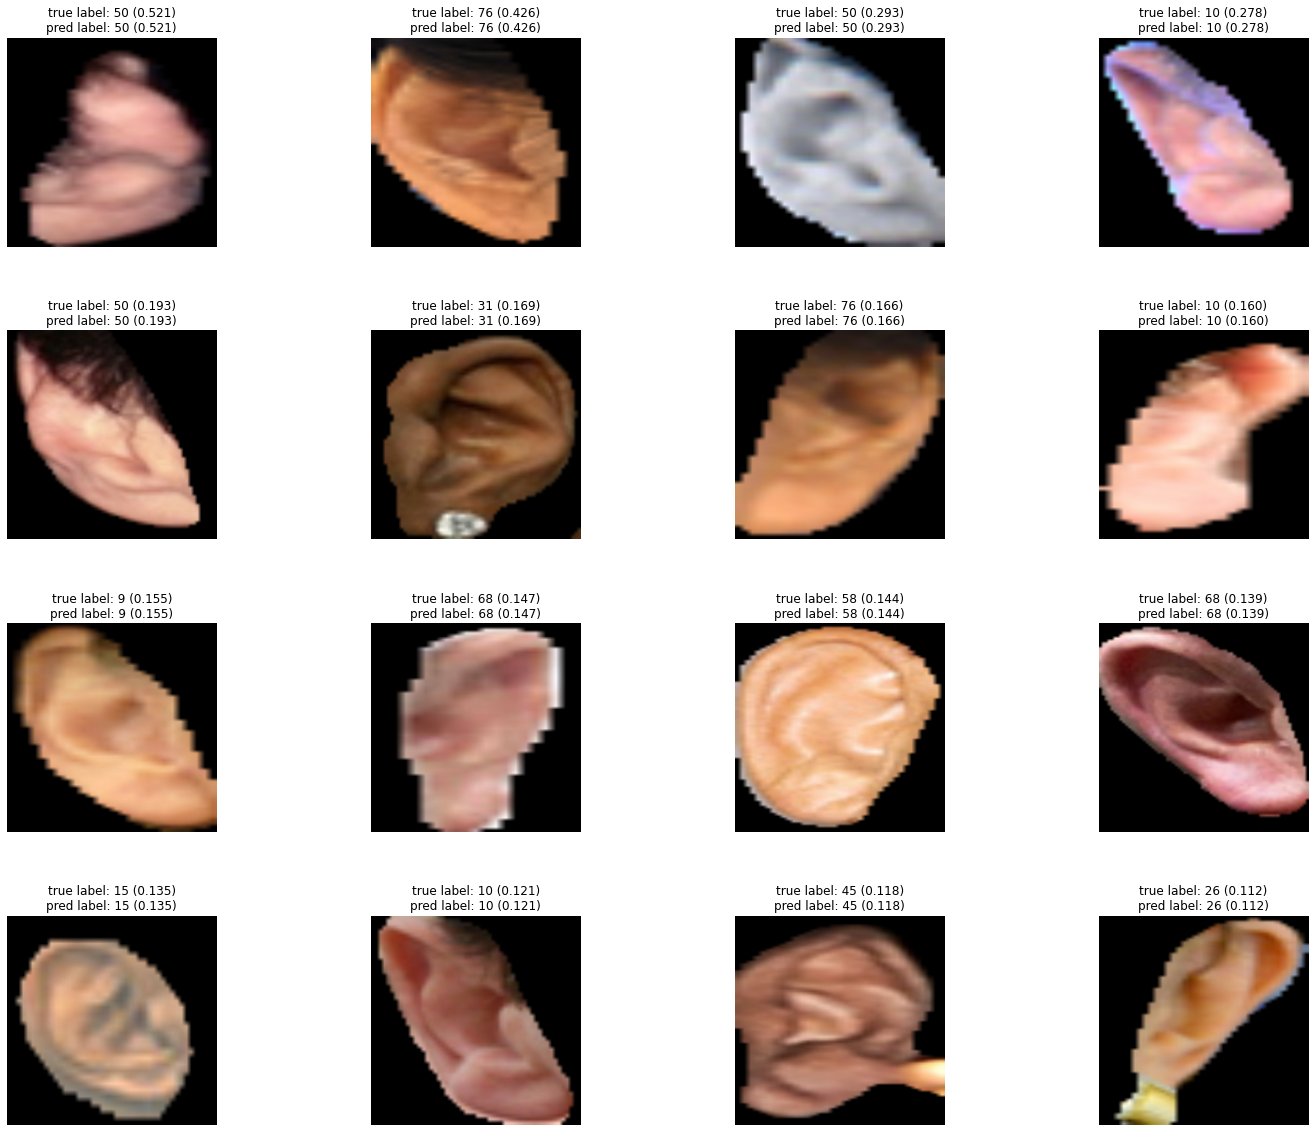

In [357]:
plot_images(correct_examples, classes, N_IMAGES)